In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Processing data

In [3]:
rca = pd.read_csv('../../data/final/rca_ensemb.csv').query('check == "pass"')
rca

,embed,norm,train_n,fold,r2_mean,check
0,CBOW_GoogleNews,Freq_HAL,8668,1,0.660651,pass
1,CBOW_GoogleNews,Freq_HAL,8668,2,0.659874,pass
2,CBOW_GoogleNews,Freq_HAL,8668,3,0.678498,pass
3,CBOW_GoogleNews,Freq_HAL,8668,4,0.657754,pass
4,CBOW_GoogleNews,Freq_HAL,8668,5,0.687100,pass
...,...,...,...,...,...,...
7295,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,1,0.512233,pass
7296,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,2,0.586266,pass
7297,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,3,0.555577,pass
7298,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,4,0.437230,pass


<AxesSubplot: >

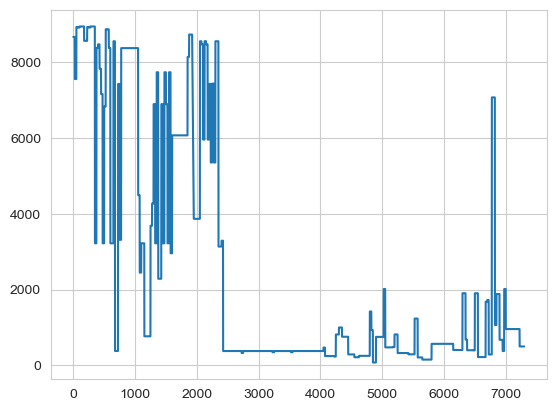

In [4]:
rca['train_n'].plot.line()

In [4]:
# Flooring r2_mean_tt at 0 so we can only improve in the positive domain
rca['r2_mean_tt'] = rca['r2_mean_tt'].clip(lower=0)
rca['r2_mean_tt'].describe()

count    5820.000000
mean        0.501868
std         0.213752
min         0.000000
25%         0.363846
50%         0.544955
75%         0.671607
max         0.850265
Name: r2_mean_tt, dtype: float64

In [5]:
# Changing category names to custom cat names
meta = pd.read_csv('../../data/raw/psychNorms_metadata.csv', index_col=0)
meta

,description,citation,category,associated_embed,type,n_ratings
norm,,,,,,
Freq_HAL,Log10 version of frequency norms based on the ...,"Lund, K. and C. Burgess (1996). ""Producing hig...",frequency,NaN,continuous,79671
Freq_KF,Log10 version of frequency norms based on the ...,"Kučera, H. and W. N. Francis (1967). Computati...",frequency,NaN,continuous,35230
Freq_SUBTLEXUS,Log10 version of frequency norms based on the ...,"Brysbaert, M. and B. New (2009). ""Moving beyon...",frequency,NaN,continuous,57214
Freq_SUBTLEXUK,Log10 version of the frequency norms based on ...,"Van Heuven, W. J., et al. (2014). ""SUBTLEX-UK:...",frequency,NaN,continuous,61843
Freq_Blog,Log10 version of the frequency norms based on ...,"Gimenes, M. and B. New (2016). ""Worldlex: Twit...",frequency,NaN,continuous,70646
...,...,...,...,...,...,...
familiarity_vanarsdall,Ratings from 1 (highly unfamiliar) to 7 (highl...,"@article{vanarsdall2022analyzing,\n title={An...",familiarity,NaN,continuous,1200
imageability_vanarsdall,Ratings from 1 (low imagery) to 7 (high imagery),"@article{vanarsdall2022analyzing,\n title={An...",imageability,NaN,continuous,1200
familiarity_fear,Ratings from 1 (extremely infrequent) to 7 (ex...,"@article{fear1997ratings,\n title={Ratings fo...",familiarity,NaN,continuous,703


In [6]:
rca['norm_category'] = (
    rca['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' ', '/': ' / '}, regex=True)
)
rca

,text_text_name,text_behavior_name,norm,train_n,r2_mean_tt,r2_mean_tb,data_check,norm_category
0,CBOW_GoogleNews&morphoNLM,CBOW_GoogleNews&PPMI_SVD_SWOW,Freq_HAL,8668,0.735002,0.718352,pass,frequency
1,CBOW_GoogleNews&morphoNLM,CBOW_GoogleNews&PPMI_SVD_SWOW,Freq_HAL,8668,0.742418,0.741171,pass,frequency
2,CBOW_GoogleNews&morphoNLM,CBOW_GoogleNews&PPMI_SVD_SWOW,Freq_HAL,8668,0.743355,0.719997,pass,frequency
3,CBOW_GoogleNews&morphoNLM,CBOW_GoogleNews&PPMI_SVD_SWOW,Freq_HAL,8668,0.728854,0.727093,pass,frequency
4,CBOW_GoogleNews&morphoNLM,CBOW_GoogleNews&PPMI_SVD_SWOW,Freq_HAL,8668,0.742810,0.740242,pass,frequency
...,...,...,...,...,...,...,...,...
5835,CBOW_GoogleNews&morphoNLM,morphoNLM&SGSoftMaxInput_SWOW,imageability_fear,500,0.667457,0.613200,pass,imageability
5836,CBOW_GoogleNews&morphoNLM,morphoNLM&SGSoftMaxInput_SWOW,imageability_fear,500,0.618295,0.573493,pass,imageability
5837,CBOW_GoogleNews&morphoNLM,morphoNLM&SGSoftMaxInput_SWOW,imageability_fear,500,0.651703,0.574030,pass,imageability
5838,CBOW_GoogleNews&morphoNLM,morphoNLM&SGSoftMaxInput_SWOW,imageability_fear,500,0.589339,0.556056,pass,imageability


In [8]:
# Calculating difference between r2_mean_tb and r2_mean_tt
rca['r2_diff'] = rca['r2_mean_tb'] - rca['r2_mean_tt']
rca

,text_text_name,text_behavior_name,norm,train_n,r2_mean_tt,r2_mean_tb,data_check,norm_category,r2_diff,behavior_embed
0,CBOW_GoogleNews&morphoNLM,CBOW_GoogleNews&PPMI_SVD_SWOW,Freq_HAL,8668,0.735002,0.718352,pass,frequency,-0.016650,PPMI_SVD_SWOW
1,CBOW_GoogleNews&morphoNLM,CBOW_GoogleNews&PPMI_SVD_SWOW,Freq_HAL,8668,0.742418,0.741171,pass,frequency,-0.001247,PPMI_SVD_SWOW
2,CBOW_GoogleNews&morphoNLM,CBOW_GoogleNews&PPMI_SVD_SWOW,Freq_HAL,8668,0.743355,0.719997,pass,frequency,-0.023358,PPMI_SVD_SWOW
3,CBOW_GoogleNews&morphoNLM,CBOW_GoogleNews&PPMI_SVD_SWOW,Freq_HAL,8668,0.728854,0.727093,pass,frequency,-0.001761,PPMI_SVD_SWOW
4,CBOW_GoogleNews&morphoNLM,CBOW_GoogleNews&PPMI_SVD_SWOW,Freq_HAL,8668,0.742810,0.740242,pass,frequency,-0.002568,PPMI_SVD_SWOW
...,...,...,...,...,...,...,...,...,...,...
5835,CBOW_GoogleNews&morphoNLM,morphoNLM&SGSoftMaxInput_SWOW,imageability_fear,500,0.667457,0.613200,pass,imageability,-0.054258,SGSoftMaxInput_SWOW
5836,CBOW_GoogleNews&morphoNLM,morphoNLM&SGSoftMaxInput_SWOW,imageability_fear,500,0.618295,0.573493,pass,imageability,-0.044802,SGSoftMaxInput_SWOW
5837,CBOW_GoogleNews&morphoNLM,morphoNLM&SGSoftMaxInput_SWOW,imageability_fear,500,0.651703,0.574030,pass,imageability,-0.077673,SGSoftMaxInput_SWOW
5838,CBOW_GoogleNews&morphoNLM,morphoNLM&SGSoftMaxInput_SWOW,imageability_fear,500,0.589339,0.556056,pass,imageability,-0.033283,SGSoftMaxInput_SWOW


In [9]:
rca_mean = (
    rca[['norm_category', 'text_behavior_name',  'r2_diff']]
    .groupby(['norm_category', 'text_behavior_name'], as_index=False).agg(['mean', 'std'])
    .reset_index()
)
rca_mean.columns =['norm_category', 'text_behavior_name', 'r2_diff_mean', 'r2_diff_std']
rca_mean

,norm_category,text_behavior_name,r2_diff_mean,r2_diff_std
0,age of acquisition,CBOW_GoogleNews&PPMI_SVD_SWOW,-0.017653,0.060429
1,age of acquisition,CBOW_GoogleNews&SGSoftMaxInput_SWOW,-0.036804,0.068178
2,age of acquisition,morphoNLM&PPMI_SVD_SWOW,-0.058031,0.098267
3,age of acquisition,morphoNLM&SGSoftMaxInput_SWOW,-0.125801,0.093283
4,animacy,CBOW_GoogleNews&PPMI_SVD_SWOW,0.024267,0.032536
...,...,...,...,...
103,valence,morphoNLM&SGSoftMaxInput_SWOW,0.034800,0.054810
104,visual lexical decision,CBOW_GoogleNews&PPMI_SVD_SWOW,-0.024768,0.040359
105,visual lexical decision,CBOW_GoogleNews&SGSoftMaxInput_SWOW,-0.042659,0.039230
106,visual lexical decision,morphoNLM&PPMI_SVD_SWOW,-0.064745,0.028858


In [10]:
# Sorts norm_category by grand mean of r2_diff 
categories = (
    rca_mean
    .groupby('norm_category')['r2_diff_mean'].mean().sort_values().index
)
rca_mean['norm_category'] = pd.Categorical(
    rca_mean['norm_category'], categories=categories, ordered=True
)
rca_mean = rca_mean.sort_values('norm_category').reset_index(drop=True)
rca_mean

,norm_category,text_behavior_name,r2_diff_mean,r2_diff_std
0,familiarity,CBOW_GoogleNews&PPMI_SVD_SWOW,-0.080785,0.627486
1,familiarity,morphoNLM&PPMI_SVD_SWOW,-0.111196,0.598821
2,familiarity,morphoNLM&SGSoftMaxInput_SWOW,-0.147140,0.586589
3,familiarity,CBOW_GoogleNews&SGSoftMaxInput_SWOW,-0.094445,0.626489
4,part of speech,CBOW_GoogleNews&PPMI_SVD_SWOW,-0.022492,0.008052
...,...,...,...,...
103,valence,morphoNLM&SGSoftMaxInput_SWOW,0.034800,0.054810
104,dominance,morphoNLM&PPMI_SVD_SWOW,0.116993,0.039463
105,dominance,CBOW_GoogleNews&SGSoftMaxInput_SWOW,0.077114,0.016551
106,dominance,CBOW_GoogleNews&PPMI_SVD_SWOW,0.124249,0.028902


In [12]:
rca['text_behavior_name'].unique()

array(['CBOW_GoogleNews&PPMI_SVD_SWOW',
       'CBOW_GoogleNews&SGSoftMaxInput_SWOW', 'morphoNLM&PPMI_SVD_SWOW',
       'morphoNLM&SGSoftMaxInput_SWOW'], dtype=object)

# Plotting

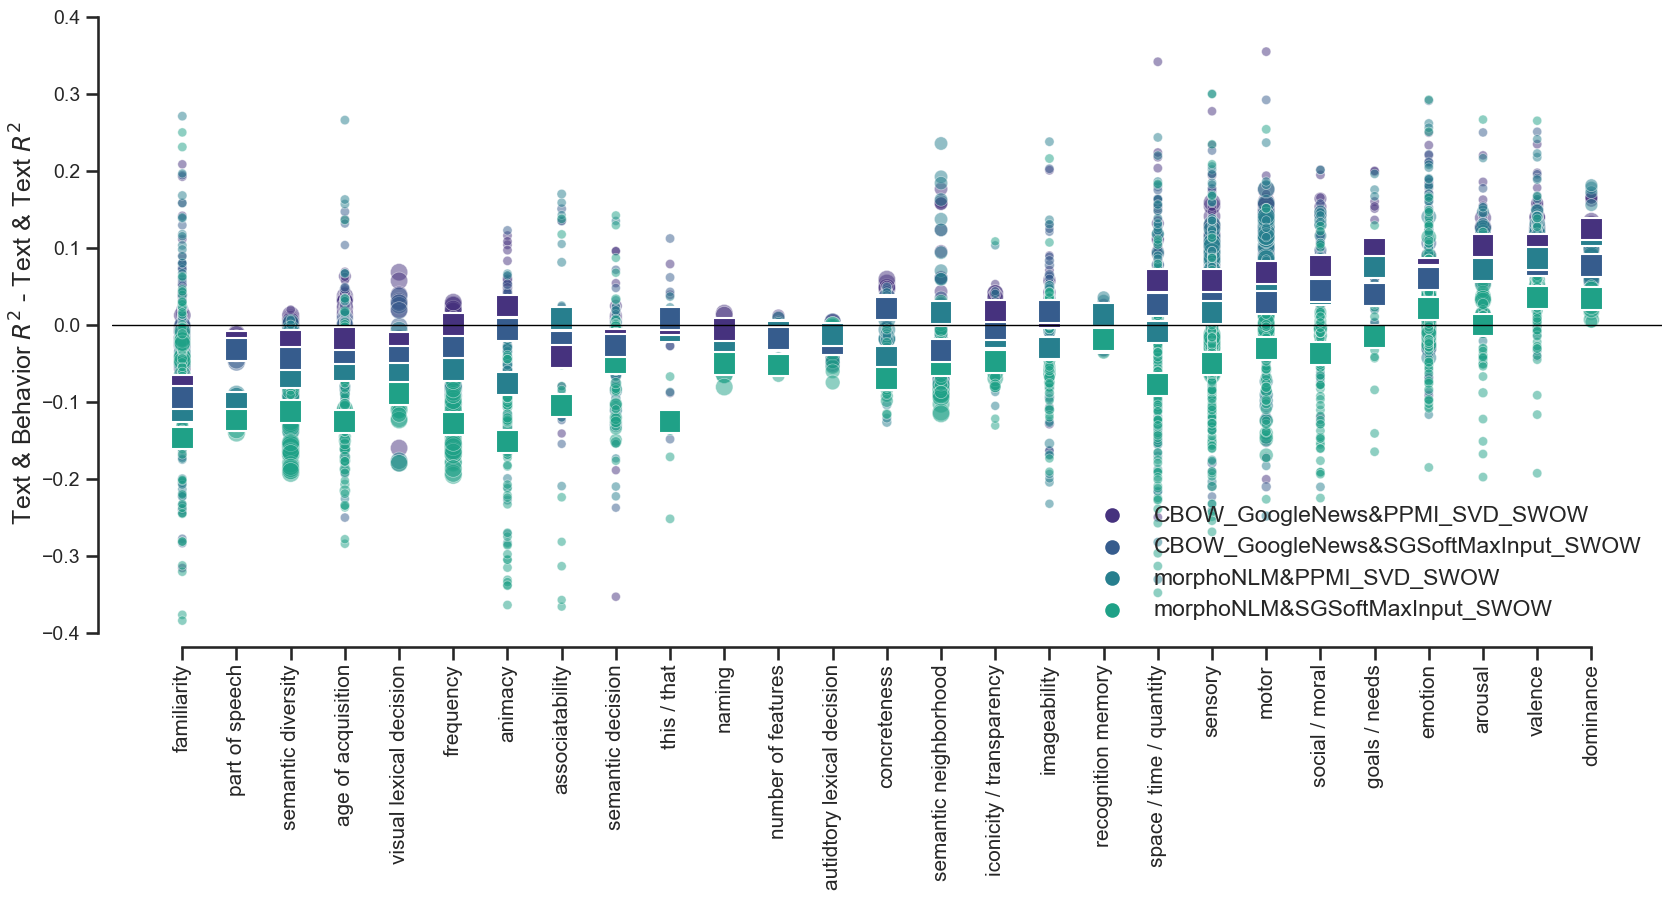

In [14]:
# 3 colors close to and including #440154'
sns.set(context='talk', style='white', palette='viridis')
fig, ax = plt.subplots(figsize=(20, 8))

# grand means
hue_order = rca['text_behavior_name'].unique()
sns.scatterplot(
    rca_mean, 
    marker='s', x='norm_category', y='r2_diff_mean', hue='text_behavior_name',
    s=270, edgecolor='white', linewidth=1.5, hue_order=hue_order,
    zorder=2, ax=ax
)

# individual norms
sns.scatterplot(
    rca,
    marker='o', x='norm_category', y='r2_diff', hue='text_behavior_name',
    size='train_n',  alpha=.5, zorder=0, hue_order=hue_order, 
    ax=ax, legend=False
)

# ax.legend_.remove()

ymin, ymax, step = -.4, .4, .1
ax.set(
    ylim=(ymin, ymax), xlabel='', ylabel=' Text & Behavior $R^2$ - Text & Text $R^2$ ',
    yticks=np.arange(ymin, ymax + step, step)
)
ax.axhline(0, color='black', lw=1)
ax.tick_params(axis='x', rotation=90, which='both', bottom=True, top=False, labelbottom=True, labelsize=15)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelsize=14)

# Moves legend to bottom right
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.24), frameon=False)

sns.despine(offset=10, trim=True)
plt.savefig('../../figures/rca_ensemb.png', dpi=300, bbox_inches='tight')

In [10]:
rca.sort_values(by='train_n')

,text_embed,ensemb_embed,norm,train_n,r2_text,r2_ensemb,data_check,penalty_check,norm_category,r2_diff,behavior_embed
1348,fastText_CommonCrawl,fastText_CommonCrawl&PPMI_SVD_SWOW,imageability_davies,679,0.682817,0.679170,pass,NaN,imageability,-0.003647,PPMI_SVD_SWOW
1342,fastText_CommonCrawl,fastText_CommonCrawl&PPMI_SVD_SWOW,aoa_davies,679,0.557519,0.539664,pass,NaN,age of acquisition,-0.017855,PPMI_SVD_SWOW
1343,fastText_CommonCrawl,fastText_CommonCrawl&PPMI_SVD_SWOW,aoa_davies,679,0.480330,0.428292,pass,NaN,age of acquisition,-0.052038,PPMI_SVD_SWOW
1344,fastText_CommonCrawl,fastText_CommonCrawl&PPMI_SVD_SWOW,aoa_davies,679,0.161048,0.146169,pass,NaN,age of acquisition,-0.014879,PPMI_SVD_SWOW
1345,fastText_CommonCrawl,fastText_CommonCrawl&PPMI_SVD_SWOW,imageability_davies,679,0.509786,0.531545,pass,NaN,imageability,0.021759,PPMI_SVD_SWOW
...,...,...,...,...,...,...,...,...,...,...,...
1439,fastText_CommonCrawl,fastText_CommonCrawl&SGSoftMaxEncoder_SWOW,Freq_News,9204,0.091400,0.165116,pass,NaN,frequency,0.073716,SGSoftMaxEncoder_SWOW
61,fastText_CommonCrawl,fastText_CommonCrawl&PPMI_SVD_SWOW,CD_Twitter,9204,0.502911,0.561958,pass,NaN,semantic diversity,0.059046,PPMI_SVD_SWOW
62,fastText_CommonCrawl,fastText_CommonCrawl&PPMI_SVD_SWOW,CD_Twitter,9204,0.519528,0.567103,pass,NaN,semantic diversity,0.047574,PPMI_SVD_SWOW
64,fastText_CommonCrawl,fastText_CommonCrawl&PPMI_SVD_SWOW,CD_Twitter,9204,0.164704,0.305213,pass,NaN,semantic diversity,0.140509,PPMI_SVD_SWOW
